# The ESA Climate Change Initative Sea Surface Temperature data

- Funding: ESA and AWS Public Dataset Program

## Credits: Tutorial development
- Niall McCarroll
- [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute


## Credits: Creating of the Zarr CCI SST dataset. 
- Niall McCarroll
- Dr. Chris Merchant
 

## Tutorial 1 - Getting Started

This tutorial helps you get started with the Sea Surface Temperature Daily Analysis dataset: European Space Agency Climate Change Initiative product version 2.1, hosted by AWS opendata.

### 1.0 Importing packages

In [11]:
import fsspec
import matplotlib.pyplot as plt
import s3fs
import xarray as xr
import numpy as np

### 1.1 Opening the dataset

The following code will load the metadata for the dataset. It is really fast because it uses 'lazy loading'. Data is only loaded when it is needed, and only the chunks that are needed are accessed.

In [2]:
# if you are running on AWS cloud you can use the line below and it will be faster to read and access the data
#ds = xr.open_zarr(fsspec.get_mapper("s3://surftemp-sst/data/sst.zarr"),consolidated=True)

# if you are running anywhere other than AWS cloud (eg. your local computer or mybinder.org) this is the line that will work
ds = xr.open_zarr('https://surftemp-sst.s3.us-west-2.amazonaws.com/data/sst.zarr')

### 1.2 Inspecting the dataset

Xarray will print out all the variables in the dataset so you can explore them. Click on the icons to the right of the data to examine the data variable attributes and see some values for the data variable. At the bottom you can explore the global attributes for the dataset. This dataset contains:

| Variable name         | Description                                              | Units   |
| --------------------- | -------------------------------------------------------- | ------- |
| analysed_sst          | Analysed sea surface temperature (Kelvin)                | kelvin  |
| analysis_uncertainty  | Estimated error standard deviation of analysed_sst       | kelvin  |
| sea_ice_fraction      | The estimated fraction of the area covered by sea ice    | -       |
| mask                  | Bit mask (bit0:sea,bit1:land:bit2:lake,bit3:ice)         | -       |


In [3]:
ds

,Array,Chunk
Bytes,1.35 TiB,49.44 MiB
Shape,"(14367, 3600, 7200)","(50, 360, 720)"
Count,28801 Tasks,28800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.35 TiB,49.44 MiB
Shape,"(14367, 3600, 7200)","(50, 360, 720)"
Count,28801 Tasks,28800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### 1.3 Plot a timeseries of the `analyzed_sst` over a specific time range

The data covers the earth's surface at a resolution of 0.05 degrees.  If you are interested in temperatures at a single location, extract a timeseries at a specific location. This is easiest to do with two .sel calls. First we select our time range. Next we select the latitude and longitude specifing `method="nearest"` to find the nearest point.

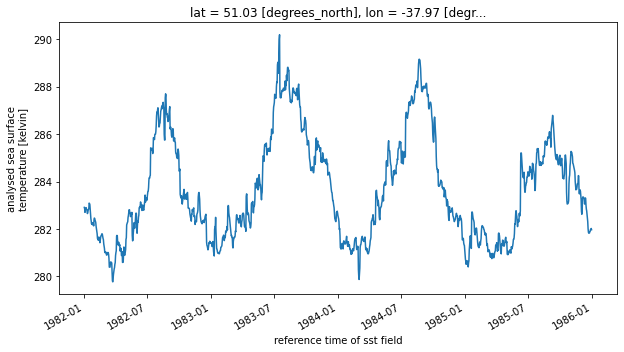

In [4]:
ds["analysed_sst"] \
    .sel(time=slice("1982-01-01", "1985-12-31")) \
    .sel(lat=51, lon=-38, method="nearest") \
    .plot(figsize=(10, 5))

### 1.4 Plot data for a specific region

it is easy to select a subset of the data for  given range of latitudes and longitudes.  For example, to see the data for a region at a single point in time:

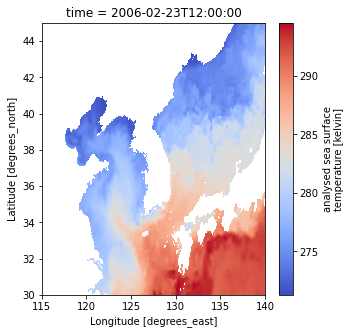

In [5]:
ds["analysed_sst"] \
    .sel(time="2006-02-23") \
    .sel(lat=slice(30, 45), lon=slice(115, 140)) \
    .plot(cmap="coolwarm", figsize=(5, 5))

### 1.5 Plotting global sea surface temperatures at a point in time

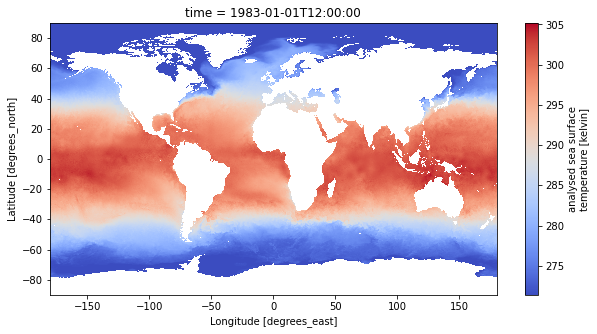

In [6]:
ds["analysed_sst"].sel(time="1983-01-01").plot(cmap="coolwarm", figsize=(10, 5))

### 1.6 Inspecting other variables in the dataset

In this dataset, the uncertainty is calculated for each pixel and included as another data variable. This can be useful when you are trying to understand how accurate the data is or how to blend it with other data or inject into a model. Here we plot the SST uncertainty data for a region (the gulf of guinea) at a single point in time:

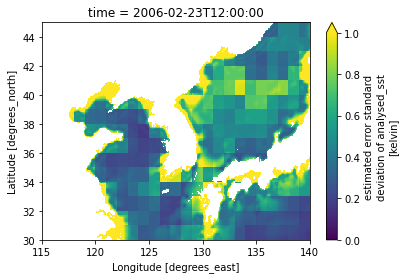

In [7]:
ds["analysed_sst_uncertainty"] \
    .sel(time="2006-02-23")    \
    .sel(lat=slice(30, 45), lon=slice(115, 140)) \
    .plot(vmin=0, vmax=1)

This dataset calculates SST for all ocean pixels, including areas covered by sea ice. In those regions the SST relaxes back to -2 C (271.15 K). For some science applications, it is important to remove data covered by sea ice. This dataset has a variable for sea ice fraction that can be used to mask the data. Here we plot the sea ice fraction for 01 Jan 1983.

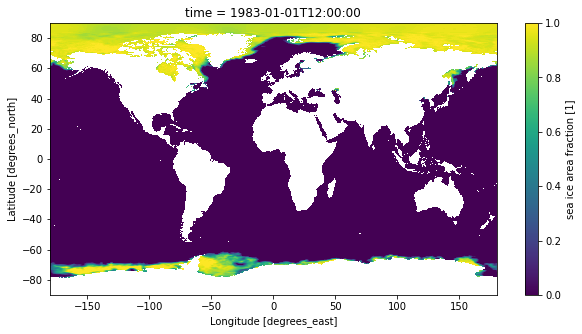

In [8]:
ds["sea_ice_fraction"] \
    .sel(time="1983-01-01") \
    .plot(vmin=0, vmax=1, figsize=(10, 5))

There is also a `mask` in the data. To see what the different values of the mask means, you can print out the attributes.

In [9]:
ds["mask"].attrs

{'comment': 'b0: 1=grid cell is open sea water b1: 1=grid cell is land b2: 1=grid cell is lake surface b3: 1=grid cell is sea ice b4-b7: reserved for future grid mask data',
 'flag_masks': [1, 2, 4, 8, 16],
 'flag_meanings': 'water land optional_lake_surface sea_ice optional_river_surface',
 'long_name': 'sea/land/lake/ice field composite mask',
 'source': 'NAVOCEANO_landmask_v1.0 EUMETSAT_OSI-SAF_icemask ARCLake_lakemask',
 'valid_max': 31,
 'valid_min': 1}

Note in the attributes that this is a bit mask flag. The bits are given in the comments. Below we set up the bit flags and then plot each bit to show the different masks individually over Scandanavia

Sea
Land
Lake
Sea Ice


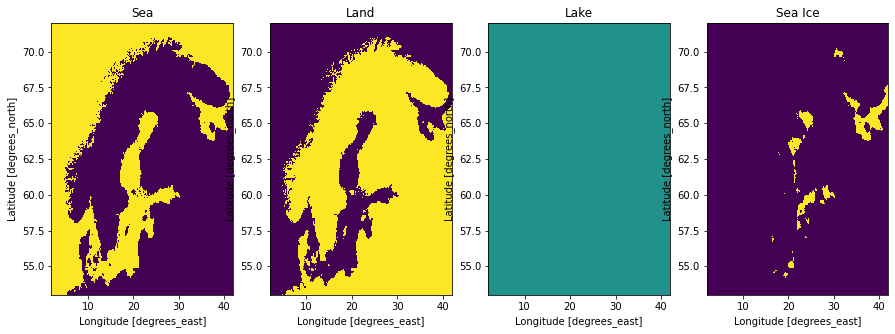

In [10]:
sea_bit,land_bit,lake_bit,seaice_bit = 0,1,2,3
bits = [sea_bit,land_bit,lake_bit,seaice_bit]
bitstr = ['Sea','Land','Lake','Sea Ice']

fig, axes = plt.subplots(ncols=4, figsize=(15, 5))

subset = (
    ds["mask"]
    .sel(time="2006-01-18")
    .sel(lon=slice(2, 42), lat=slice(53, 72))
)

for ib,bit in enumerate(bits):
    print(bitstr[bit])
    subset_mask = np.bitwise_and(subset.astype('uint8'), int(2**bit)) > 0
    subset_mask.plot(ax=axes[bit],add_colorbar=False)
    axes[bit].set_title(bitstr[bit])